# Multi-feature GLM demo

In [24]:
import glm_utils
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.model_selection
import scipy.stats
import scipy.signal
from demo_utils import get_data
plt.style.use('ncb.mplstyle')

## Get data
In this demo we will work with a response (y) which has been constructed from a randomly generated stimulus with 4 features. We can use a GLM to:
- determine the importance of each stimulus feature 
- the temporal pattern driving the response for each stimulus feature.

x: (100000, 4), y: (100000,), filters (50, 4)


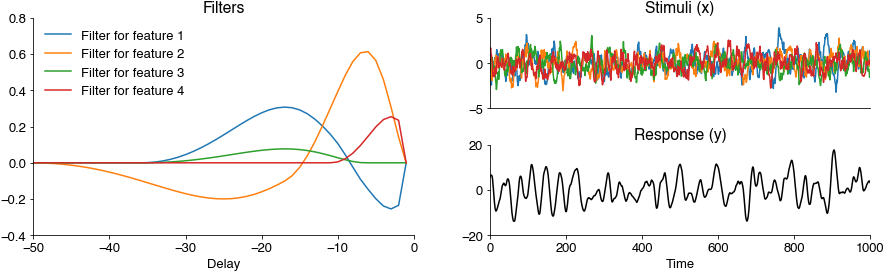

In [25]:
x, y, filters = get_data(npoints = 100_000)

nb_points, nb_stim = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.legend([f'Filter for feature {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('Stimuli (x)')
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('Response (y)')
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

Normalize each feature and perform time-delay embedding. The different features are concatenated along the delay axis.

In [26]:
x = scipy.stats.zscore(x, axis=0)
Xmulti, ymulti = glm_utils.preprocessing.time_delay_embedding(x, y, window_size=filter_duration, flatten_inside_window=True)
print(f"Xmulti: {Xmulti.shape}, ymulti: {ymulti.shape}")

Xmulti: (99950, 200), ymulti: (99950,)


Define basis (see [basis_functions](basis_functions.ipynb)).
To deal with the concatenated features, we construct a `multifeature_basis`, which contains duplicates of the original bases along the diagonal.

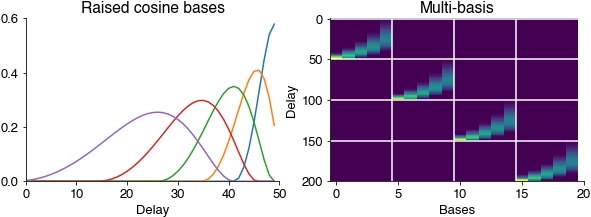

In [31]:
# define bases
B = glm_utils.bases.raised_cosine(0, 5, [0, 23], 9, filter_duration)
B_multi = glm_utils.bases.multifeature_basis(B, nb_stim)
basis_multi_projection = glm_utils.preprocessing.BasisProjection(B_multi)
_, nbases = B.shape

plt.figure(figsize = [10,3])
plt.subplot(121)
plt.plot(B)
plt.title('Raised cosine bases')
plt.xlabel('Delay')

plt.subplot(122)
plt.imshow(B_multi)
plt.hlines(np.arange(0, nb_stim*filter_duration,filter_duration), -0.5, B_multi.shape[1], colors='w')
plt.vlines(np.arange(0, nb_stim*nbases,nbases)-0.5, 0, B_multi.shape[0], colors='w')
plt.axis('tight')
plt.ylabel('Delay')
plt.xlabel('Bases')
plt.title('Multi-basis')
plt.show()

Project data onto basis.

In [32]:
Xmulti_b = basis_multi_projection.transform(Xmulti)
print(f"Before [T, delays]: X {Xmulti.shape},  y {ymulti.shape}.")
print(f"After [T, bases]: X {Xmulti_b.shape},  y {ymulti.shape}.")

Before [T, delays]: X (99950, 200),  y (99950,).
After [T, bases]: X (99950, 20),  y (99950,).


Split data into train and test sets.

In [33]:
# choose how many random samples to take from the data (less or equal than the available data, nb_points)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Xmulti_b, ymulti, test_size=0.2)
print(f"Shape of training set: {X_train.shape}, test set: {X_test.shape}")

Shape of training set: (79960, 20), test set: (19990, 20)


## Fit a model

Fit a glm model using the training data and assess model performance. 
Lasso regression minimizes the number of non-zero coefficients while maximizing the model performance through a process called _regularization_. 

In [34]:
lr = sklearn.linear_model.LassoCV()
lr.fit(X_train, y_train)
print(f'score: {lr.score(X_test, y_test):1.2f}')

score: 1.00


# Filter reconstruction
Reconstruct the filters for each feature. If all features are z-scored prior to fitting, then the filter magnitude (L2 norm) corresponds to the "importance" of each feature. The shape of the filters depicts how information from the features is integrated over time to produce the response.

The model coefficients, `lr.coef_`, correspond to weights for the different basis functions. The `inverse_transform` method of the `BasisProjection` class reconstructs the filters from these weights (see [basics](basics.ipynb)). Since the model was fit with features that were concatenated, we "unconcatenate" the filters by reshaping the resulting array.

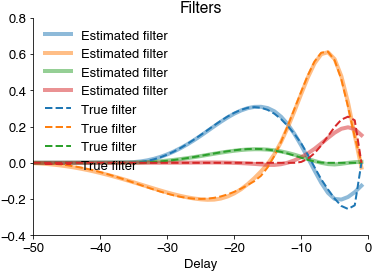

In [35]:
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delay')
plt.title('Filters')
plt.legend(loc='upper left')
plt.show()

## Effect of noise

Now, let's see the effect of noise in the response. We can simulate this by adding different levels of noise to the response, thus making the match between inputs and signal imperfect.

As you can see, the performance of the model decreases with the noise level, but the shape of the filters is stable, even for the highest noise level.

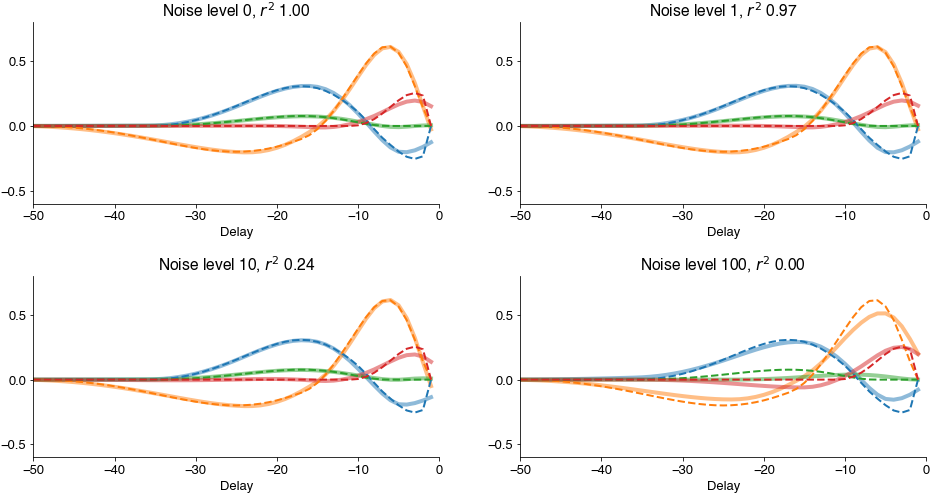

In [36]:
noise_levels = [0, 1, 10, 100]

plt.figure(figsize=(16, 8))
for jj, noise_level in enumerate(noise_levels):
    
    # add noise to the response
    y_train_noisy = y_train + np.random.normal(0, noise_level, len(y_train))
    y_test_noisy = y_test + np.random.normal(0, noise_level, len(y_test))


    # train
    lr = sklearn.linear_model.LassoCV()
    lr.fit(X_train, y_train_noisy)

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1, filter_duration))

    # plot
    plt.subplot(2, 2, jj+1)

    plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
    plt.gca().set_prop_cycle(None)
    plt.plot(T, filters, '--', linewidth=2, label='True filter')
    plt.xlabel('Delay')
    plt.title(f'Noise level {noise_level}, $r^2$ {lr.score(X_test, y_test_noisy):0.2f}')
    plt.ylim([-0.6, 0.8])
    if jj > 1:
        plt.xlabel('Delay')
plt.subplots_adjust(hspace=0.4)
plt.show()

## Missing features

What happens to the model performance and the filter shapes if we can't measure all relevant features? To emulate this, we will fit a model using only the first two features. Because we are modifying the number of inputs, we also need to create a new `multifeature_basis` and a new `BasisProjection`.

Omitting features reduces the model performance, but the filters for the remaining features are correctly reconstructed.

incomplete model score: 0.94


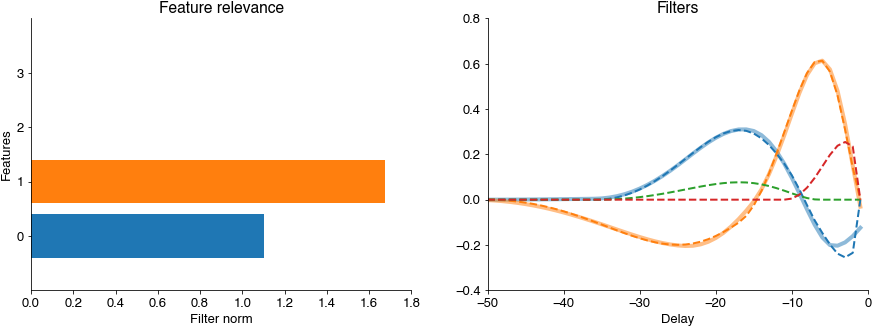

In [37]:
nb_stim_incomplete = 2

# bases
B_incomplete = glm_utils.bases.multifeature_basis(B, nb_stim_incomplete)
basis_projection_incomplete = glm_utils.preprocessing.BasisProjection(B_incomplete)

# time-delay-embedding
X_incomplete, ymulti = glm_utils.preprocessing.time_delay_embedding(x[:, :2], y, window_size=filter_duration, flatten_inside_window=True)

# project
X_incomplete_b = basis_projection_incomplete.transform(X_incomplete)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_incomplete_b, ymulti, test_size=0.2)

# train
lr = sklearn.linear_model.LassoCV()
lr.fit(X_train, y_train)
print(f'incomplete model score: {lr.score(X_test, y_test):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_incomplete.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(nb_stim_incomplete):
    plt.barh(ii, filt_norms[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim),np.arange(nb_stim))
plt.ylim([-1,4])
plt.subplot(122)
plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delay')
plt.title('Filters')
plt.show()

## Irrelevant features

Another common situation is the presence of features that are not relevant for the response. In this example, we construct an irrelevant feature from random noise. The model correctly "recognizes" the new feature as irrelevant, and sets the filter for the irrelevant feature to zero. For real  data, even irrelevant features often have some correlation with relevant features, and even irrelevant features will get some weight in the model - regularization typically suppresses contributions from unimportant features.

irrelevant model score: 1.00


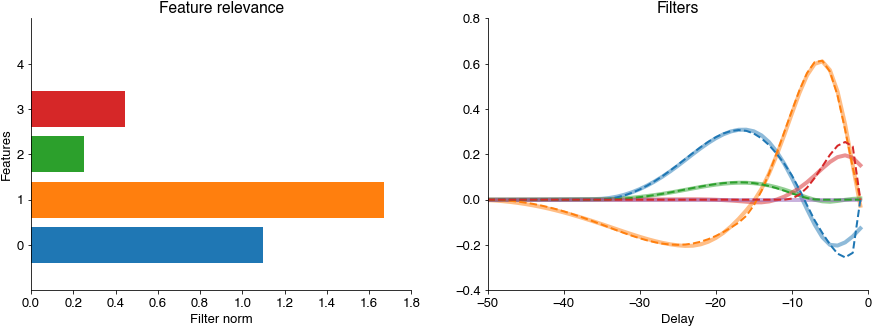

In [38]:
# data
x_irrelevant = np.concatenate((x,np.random.normal(0, 1, x[:,0].shape)[:,np.newaxis]),axis=1)

# bases
B_irrelevant = glm_utils.bases.multifeature_basis(B, nb_stim+1)
basis_projection_irrelevant = glm_utils.preprocessing.BasisProjection(B_irrelevant)

# time-delay-embedding
X_irrelevant, ymulti = glm_utils.preprocessing.time_delay_embedding(x_irrelevant, y, window_size=filter_duration, flatten_inside_window=True)

# project
X_irrelevant_b = basis_projection_irrelevant.transform(X_irrelevant)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_irrelevant_b, ymulti, test_size=0.2)

# train
lr = sklearn.linear_model.LassoCV()
lr.fit(X_train, y_train)
print(f'irrelevant model score: {lr.score(X_test, y_test):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_irrelevant.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.subplot(122)
plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delay')
plt.title('Filters')
plt.show()

## Single- vs. multi-feature models

All models so far were _multi-feature models_ - a model was fit with multiple features. An alternative approach is to fit and compare _single-feature models_ - one model per feature. To demonstrate the advantages of a multi-feature model, we will compare it to single-feature models.

In order to do this, let's continue using our previous example with an irrelevant feature. We already have the filters and test scores for the multi-feature model, so let's save those for later.

In [41]:
integrated_model_score = lr.score(X_test, y_test)

integrated_model_filters = estimated_filters
int_filt_norms = np.linalg.norm(integrated_model_filters, axis=1)

Generate single-feature models, one feature at a time.

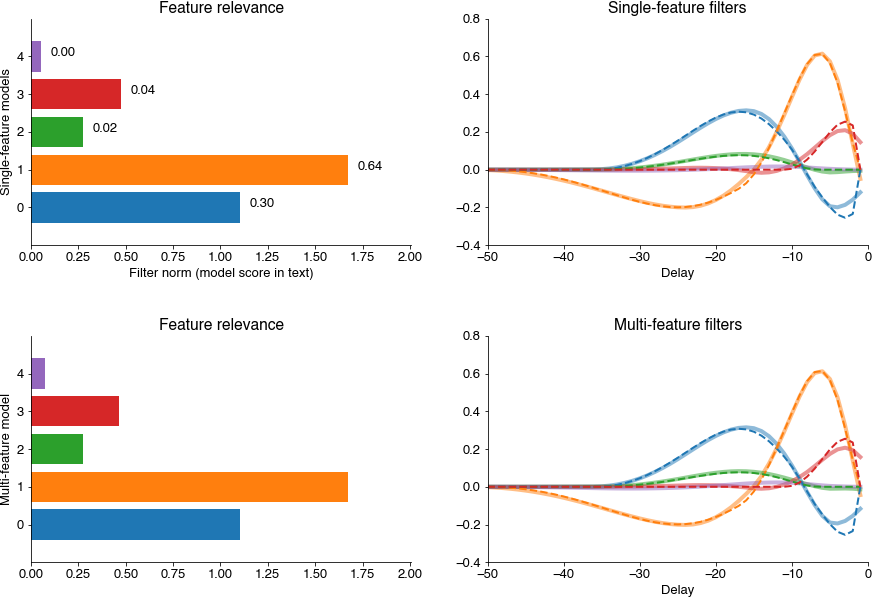

In [42]:
# indidivual basis
basis_projection = glm_utils.preprocessing.BasisProjection(B)

# lists to collect results per individual model
scores_list = []
estimated_filters_list = []

# loop through all the inputs
for ii in range(nb_stim+1):

    # time-delay-embedding
    Xs, ys = glm_utils.preprocessing.time_delay_embedding(x_irrelevant[:,ii], y, window_size=filter_duration, flatten_inside_window=True)

    # project
    Xs_b = basis_projection.transform(Xs)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Xs_b, ys, test_size=0.2)

    # train
    lr = sklearn.linear_model.LassoCV()
    lr.fit(X_train, y_train)

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1, filter_duration))

    # save results
    scores_list.append(lr.score(X_test, y_test))
    estimated_filters_list.append(np.squeeze(estimated_filters))


# plot
features_names = [f'feature {ii}' for ii in range(nb_stim+1)]
estimated_filters = np.asarray(estimated_filters_list)
filt_norms = np.linalg.norm(estimated_filters, axis=1)

plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms[ii])
    plt.text(filt_norms[ii]+0.05, ii, s=f"{scores_list[ii]:0.2f}")
plt.xlabel('Filter norm (model score in text)')
plt.title('Feature relevance')
plt.ylabel('Single-feature models')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(222)
for ii in range(nb_stim+1):
    plt.plot(T,estimated_filters_list[ii], linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delay')
plt.title('Single-feature filters')

plt.subplot(223)
for ii in range(nb_stim+1):
    plt.barh(ii, int_filt_norms[ii])
plt.yticks(np.arange(nb_stim+1),features_names)
plt.title('Feature relevance')
plt.ylabel('Multi-feature model')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(224)
plt.plot(T, integrated_model_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delay')
plt.title('Filters')
plt.title('Multi-feature filters')
plt.subplots_adjust(hspace=0.4)
plt.show()


The multi-feature model completely suppresses the filter for the irrelevant feature. By contrast, the single-feature model produces a zero test score but a non-zero filter for the irrelevant feature.

## Redundant features

What happens in the presence of redundant (a.k.a. colinear) features. In this example the redundant feature is constructed by adding two of our previous features - the new feature 4 is the sum of - and therefore partly redundant with - features 1 and 2.

Standard linear regression fails in this case since the coefficients. The filters for the redundant features have a large magnitude ($10^10$) and they are inverses of each other - their effects on the prediction cancel each other. This is where regularization becomes extremely useful since it minimizes the number of non-zero coefficients while maximizing the model performance through a process called _regularization_. Regularization avoids the blow-up of the filters and reduces the weights for redundant features to zero.

Standard linear regression, model score: 1.00
LASSO, model score: 1.00


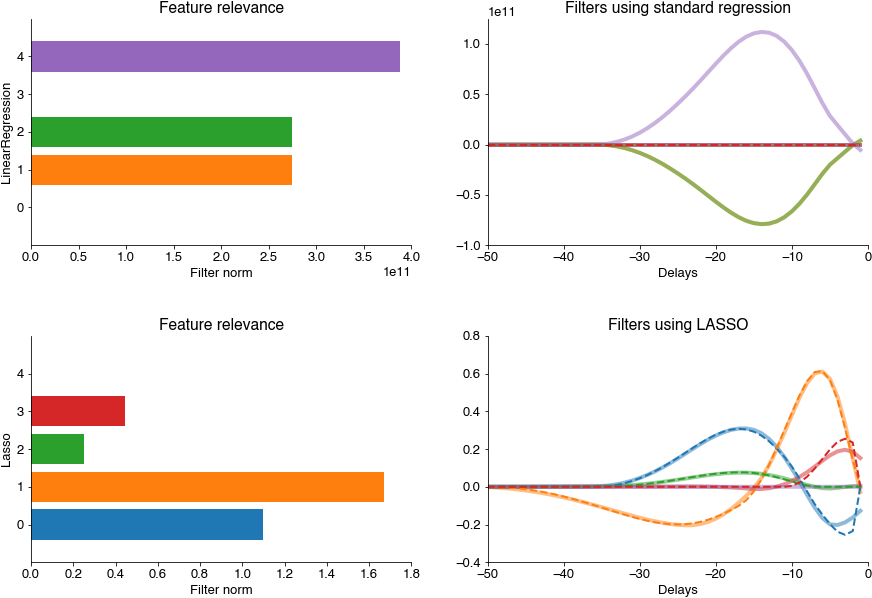

In [43]:
# data
x_redundant = np.concatenate((x,x[:,[1]]+x[:,[2]]),axis=1)
x_redundant[:,4] = (x_redundant[:,4] - np.mean(x_redundant[:,4]))/np.std(x_redundant[:,4])

# bases
B_redundant = glm_utils.bases.multifeature_basis(B, nb_stim+1)
basis_projection_redundant = glm_utils.preprocessing.BasisProjection(B_redundant)

# time-delay-embedding
X_redundant, ymulti = glm_utils.preprocessing.time_delay_embedding(x_redundant, y, window_size=filter_duration, flatten_inside_window=True)

# project
X_redundant_b = basis_projection_redundant.transform(X_redundant)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_redundant_b, ymulti, test_size=0.2)


# train
lr_red = sklearn.linear_model.LinearRegression()
lr_red.fit(X_train, y_train)
print(f'Standard linear regression, model score: {lr_red.score(X_test, y_test):1.2f}')

# reconstruct
basis_weights = lr_red.coef_
estimated_filters_lr = basis_projection_redundant.inverse_transform(basis_weights)
estimated_filters_lr = estimated_filters_lr.reshape((-1,filter_duration))
filt_norms = np.linalg.norm(estimated_filters_lr, axis=1)

# train (with lasso)
lr_lasso = sklearn.linear_model.LassoCV()
lr_lasso.fit(X_train, y_train)
print(f'LASSO, model score: {lr_lasso.score(X_test, y_test):1.2f}')

# reconstruct (with lasso)
basis_weights_lasso = lr_lasso.coef_
estimated_filters_lasso = basis_projection_redundant.inverse_transform(basis_weights_lasso)
estimated_filters_lasso = estimated_filters_lasso.reshape((-1,filter_duration))
filt_norms_lasso = np.linalg.norm(estimated_filters_lasso, axis=1)

# relevance plot for lr_red
plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.ylabel('LinearRegression')
plt.subplot(222)
plt.plot(T, estimated_filters_lr.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delays')
plt.title('Filters using standard regression')

# relevance plot for lasso
plt.subplot(223)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms_lasso[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.ylabel('Lasso')
plt.subplot(224)
plt.plot(T, estimated_filters_lasso.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delays')
plt.title('Filters using LASSO')
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.show()